## OBJECTIVE:
# DETECTING PNEUMONIA DISEASES BY PASSING CHEST XRAY SCAN OF DIFFERENT PATIENTS USING THE MobileNet_V2 CNN ARCHITECTURE

In [ ]:
# Loading all the Libraries which we will be using in our prediction
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout,Flatten,Conv2D,MaxPooling2D
from sklearn.model_selection import train_test_split
import cv2
import zipfile
import os
from matplotlib import pyplot as plt
import random as rand
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from collections import Counter

In [ ]:
# Extracting the Folders which has images of different classes
with zipfile.ZipFile('/content/drive/MyDrive/chest_xray.zip','r') as zip_file:
  zip_file.extractall('')

In [ ]:
# USING IMAGE DATA GENERATOR TO DO THE IMAGE AUGMENTATION ON OUR DATASET
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip=  True)

test_datagen = ImageDataGenerator(rescale = 1./255) 

Loading the data
OUR DATASET CONTAINS 2 CLASSES OF IMAGES
1. NORMAL XRAY IMAGES OF PATIENTS
2. PNEUMONIA AFFECTED PATIENTS XRAY IMAGES

In [ ]:

train_data = train_datagen.flow_from_directory('/content/chest_xray/train', target_size = (224,224), batch_size = 32,
                                               class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [ ]:
test_data = test_datagen.flow_from_directory('/content/chest_xray/test', target_size = (224,224), batch_size = 32,
                                               class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [ ]:
# Names of all the classes present
all_classes = train_data.class_indices
print(all_classes)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
counter =Counter(train_data.classes)

In [ ]:
# CHECKING THE NUMBER OF IMAGES WE HAVE FOR EACH CLASS
print(counter)
print(counter.values())

Counter({1: 3875, 0: 1341})
dict_values([1341, 3875])


In [ ]:
# TAKING THE MAX VALUE FROM OUR COUNTER VARIABLE WHICH WE WILL USING FURTHER TO INFER CLASS WEIGHTS
max_val = float(max(counter.values()))

In [ ]:
# ADDING WEIGHTS TO THE CLASS WHICH HAS LESS NUMBER OF SAMPLES , SO THAT THE CLASS WHICH HAS LESS NUMBER OF SAMPLES WILL GET BIT HIGHER WEIGHTAGE WHILE TRAINING SO THAT OUR MODEL CAN PREDICT BOTH THE CLASSES 
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

In [ ]:
# These are the class weights, as the class "NORMAL"  has less images so it got more weightage which we will use in the model fitting
print(class_weights)

{0: 2.889634601043997, 1: 1.0}


# PLOTTING THE IMAGES

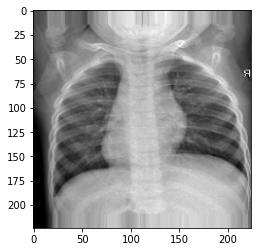

NORMAL


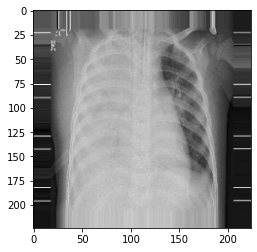

PNEUMONIA


In [ ]:
for j in range(len(train_data[0][1])):
  if list(train_data[0][1][j])[0]==1.:
    plt.imshow(train_data[0][0][j])
    plt.show()
    print(list(all_classes.keys())[0])
    break
for j in range(len(train_data[0][1])):
  if list(train_data[0][1][j])[1]==1.:
    plt.imshow(train_data[0][0][j])
    plt.show()
    print(list(all_classes.keys())[1])
    break

In [ ]:
# Loading the mobilenet model
mobilenet = tf.keras.applications.MobileNetV2(input_shape = (224,224,3), weights ='imagenet',include_top = False )

In [ ]:
# don't train the existing weights: We will be using the the exisiting model weights as well for our model
for layers in mobilenet.layers:
  layers.trainable = False

In [ ]:
mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
# ADDING OUR CUSTOM TOP LAYER TO OUR VGG19 MODEL AS OUR VGG19 MODEL WAS TRAINED ON 1000 CLASSES, WHILE IN OUR DATASET WE HAVE ONLY 2 CLASSES
flatten = Flatten()(mobilenet.output)
dense = Dense(64, activation = 'relu')(flatten)
dense = Dense(32, activation = 'relu')(dense)
prediction = Dense(2, activation = 'softmax')(dense)

In [ ]:
#creating a model
model = Model(inputs = mobilenet.input, outputs = prediction)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
# COMPILING THE MODEL

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
#executing the model
history = model.fit_generator(train_data, validation_data = (test_data), epochs = 10, verbose = 1, class_weight = class_weights)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
163/163 [==============================] - 124s 745ms/step - loss: 0.6984 - accuracy: 0.9070 - val_loss: 0.3155 - val_accuracy: 0.8878
Epoch 2/10
163/163 [==============================] - 121s 742ms/step - loss: 0.2448 - accuracy: 0.9461 - val_loss: 0.3563 - val_accuracy: 0.8990
Epoch 3/10
163/163 [==============================] - 121s 740ms/step - loss: 0.1656 - accuracy: 0.9572 - val_loss: 0.6490 - val_accuracy: 0.8189
Epoch 4/10
163/163 [==============================] - 120s 734ms/step - loss: 0.1459 - accuracy: 0.9624 - val_loss: 0.3462 - val_accuracy: 0.9038
Epoch 5/10
163/163 [==============================] - 121s 743ms/step - loss: 0.1137 - accuracy: 0.9712 - val_loss: 0.2379 - val_accuracy: 0.9167
Epoch 6/10
163/163 [==============================] - 119s 728ms/step - loss: 0.1057 - accuracy: 0.9732 - val_loss: 0.3170 - val_accuracy: 0.9054
Epoch 7/10
163/163 [==============================] - 121s 740ms/step - loss: 0.0971 - accuracy: 0.9732 - val_loss: 0.2706 -

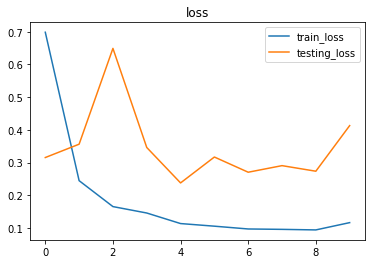

In [ ]:
# plotting the loss
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

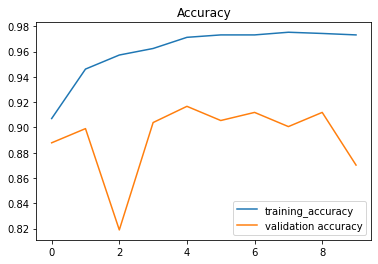

In [ ]:
# Both Validation and Training accuracy is shown here

plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# CHECKING THE CONFUSION MATRIX

Y_pred = model.predict_generator(test_data)
y_pred = np.argmax(Y_pred ,axis =1)
print('Confusion Matrix')
confusion_matrix = confusion_matrix(test_data.classes, y_pred)
print(confusion_matrix)
print('Classification Report')
target_names = ['NORMAL','PNEUMONIA']
print(classification_report(test_data.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[102 132]
 [181 209]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.36      0.44      0.39       234
   PNEUMONIA       0.61      0.54      0.57       390

    accuracy                           0.50       624
   macro avg       0.49      0.49      0.48       624
weighted avg       0.52      0.50      0.51       624



In [ ]:
# SAVING OUR MODEL

tf.saved_model.save(model, 'mobilenet_custom_model')

INFO:tensorflow:Assets written to: vgg19_custom_model/assets
